# How to store analysis results in BigQuery and Cloud Storage

In this notebook we use public data to perform a simplistic analysis, storing the resulting image file of the plot to Cloud Storage and derivied data as a BigQuery table.

<div class="alert alert-block alert-info">
<b>Tip:</b> See also the companion Terra Support article <a href='https://support.terra.bio/hc/en-us/articles/360051229072-Accessing-Advanced-GCP-features-in-Terra'>Accessing Advanced GCP features in Terra</a>.
</div>

# Setup

Edit the global variables in your clone of this notebook to refer to a native Google Cloud Platform project to which you have WRITE acces.
* **The destination Cloud Storage bucket should already exist. Your pet account must have WRITE access to it.**       
[**Click for step-by-step instructions to create a bucket**](https://support.terra.bio/hc/en-us/articles/360051229072#h_01ENRE43JJYSFHNDC02YGWFYWJ)     

* **The destination BigQuery dataset should already exist. Your pet account must have WRITE access to it.**       
[**Click for step-by-step instructions to create a BQ dataset**](https://support.terra.bio/hc/en-us/articles/360051229072#h_01EPCCS08S69VE4VMT0F0NNDWR)     

* Make sure to change to your own project, bucket, and dataset names. The remaining cells can be run as-is.

In [1]:
import os
import pandas as pd
import plotnine
from plotnine import *
import tensorflow as tf
import time

In [2]:
# Set a default plot size.
plotnine.options.figure_size = (10, 6)

**Note that you will need to change the variables below to your own values** (expand the tips if you need help finding the variables)

In [3]:
# CHANGE THESE VARIABLES
PROJECT_ID = 'your_GCP-native_project_ID'
BUCKET = 'gs://your-bucket'
BQ_DATASET = 'your_BQ_dataset'

### <font color="#FF6600">(expand for tip) </font> <font color="#445555">How to find your cloud-native project-ID</font><a class="tocSkip">

When logged in with your Terra user-ID, go to billing in the GCP console at [https://console.cloud.google.com/billing](https://console.cloud.google.com/billing)     
![finding project ID screen shot](https://storage.googleapis.com/terra-featured-workspaces/QuickStart/Advanced-GCP-features_Find-Project-ID_Step1_Screen%20shot.png)

1. Select the Organization you used when creating your cloud-native project    
2. Find the Project ID at right  

### <font color="#FF6600">(expand for tip) </font> <font color="#445555">How to find your cloud-native BigQuery dataset</font><a class="tocSkip">

Go to [https://console.cloud.google.com/bigquery](https://console.cloud.google.com/bigquery)   

On the left column, select your cloud-native Project from the drop-down. You should see your BQ dataset listed:   

![Find BQ dataset Screen shiot](https://storage.googleapis.com/terra-featured-workspaces/QuickStart/Advanced-GCP-features_Find-BQ-dataset-name_Screen%20shot.png)

# Analyze public data

## Load data from BigQuery

In [5]:
df = pd.io.gbq.read_gbq('''
  SELECT
    *
  FROM
    `genomics-public-data.1000_genomes.sample_info`
''')

df.shape

(3500, 62)

In [6]:
df.head()

Sample Family_ID Population           Population_Description  Gender  \
0  HG00144    GBR001        GBR  British in England and Scotland  female   
1  HG00147   GBR002a        GBR  British in England and Scotland  female   
2  HG00153    GBR003        GBR  British in England and Scotland  female   
3  HG00248    GBR004        GBR  British in England and Scotland  female   
4  HG00377   HG00377        FIN               Finnish in Finland  female   

  Relationship Unexpected_Parent_Child Non_Paternity Siblings Grandparents  \
0       mother                 HG00155                                       
1        child                                        HG00146                
2        child                                                               
3        child                 HG00247                                       
4                                                                            

   ... In_Final_Phase_Variant_Calling Has_Omni_Genotypes Has_Axiom_Genotypes  \
0  ...                           None               None                None   
1  ...                           None               None                None   
2  ...                           None               True                None   
3  ...                           None               None                None   
4  ...                           None               True                None   

  Has_Affy_6_0_Genotypes Has_Exome_LOF_Genotypes EBV_Coverage  \
0                   None                    None          NaN   
1                   None                    None          NaN   
2                   None                    True          NaN   
3                   None                    None          NaN   
4                   None                    True          NaN   

  DNA_Source_from_Coriell Has_Sequence_from_Blood_in_Index Super_Population  \
0                                                     None              EUR   
1                                                     None              EUR   
2                                                     None              EUR   
3                                                     None              EUR   
4                                                     None              EUR   

  Super_Population_Description  
0                     European  
1                     European  
2                     European  
3                     European  
4                     European  

[5 rows x 62 columns]

## Plot the data

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 820 rows containing non-finite values.


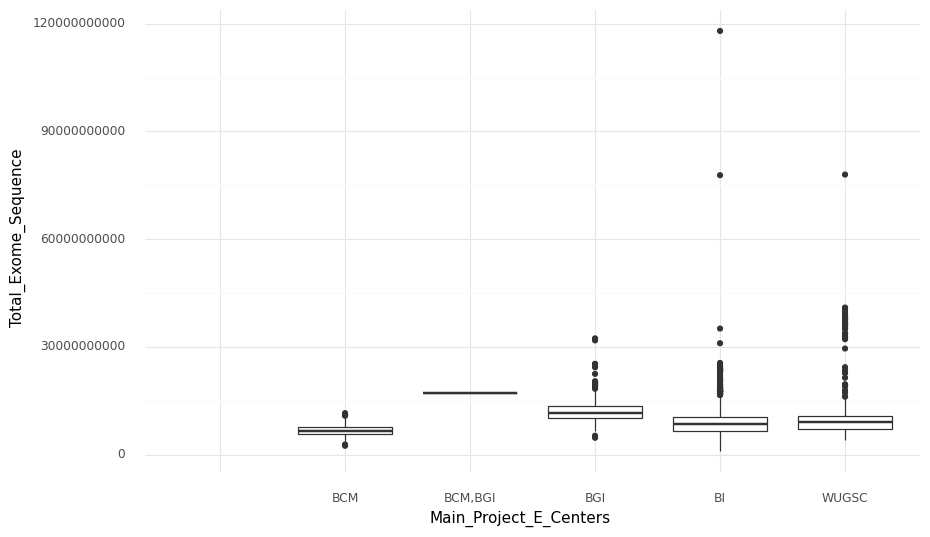

<ggplot: (8771568443433)>

In [7]:
p = (ggplot(df, aes(x='Main_Project_E_Centers', y='Total_Exome_Sequence')) +
 geom_boxplot() +
 theme_minimal()
)
p

## Save the plot to Cloud Storage

In [8]:
filename = 'plot-from-terra-' + time.strftime("%Y%m%d-%H%M%S") + '.png'
with tf.io.gfile.GFile(os.path.join(BUCKET, filename), 'w') as f:
  p.save(f, format='png', dpi=150)

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 6 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: <tensorflow.python.platform.gfile.GFile object at 0x7fa4a3808c10>
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 820 rows containing non-finite values.


Fix the content type on the images so that we can view them directly in the Cloud Console.

In [9]:
!gsutil -m setmeta -h 'Content-Type:image/png' $BUCKET/$filename

Setting metadata on gs://ah-native-gcp-project-74939-autodelete-after-one-day/plot-from-terra-20210520-162421.png...
/ [1/1 objects] 100% Done                                                       
Operation completed over 1 objects.                                              


In [10]:
print(f"""
       The plot image can now be viewed at 
       https://console.cloud.google.com/storage/browser/{BUCKET[len('gs://'):]}?project={PROJECT_ID}
       """)


       The plot image can now be viewed at 
       https://console.cloud.google.com/storage/browser/ah-native-gcp-project-74939-autodelete-after-one-day?project=ah-native-gcp-project-74939
       


## Write the dataframe to BigQuery

In [11]:
df.iloc[:,0:10].to_gbq(
    '.'.join([BQ_DATASET, 'dataframe_from_terra_' + time.strftime("%Y%m%d_%H%M%S")]),
    project_id=PROJECT_ID)

1it [00:02,  2.78s/it]


In [12]:
print(f"""
       The the BigQuery table can now be viewed at
       https://console.cloud.google.com/bigquery?project={PROJECT_ID}
       """)


       The the BigQuery table can now be viewed at
       https://console.cloud.google.com/bigquery?project=ah-native-gcp-project-74939
       


# Provenance

In [13]:
import datetime
print(datetime.datetime.now())

2021-05-20 16:24:29.634051


In [14]:
!pip3 freeze

absl-py==0.12.0
anyio==3.1.0
argon2-cffi==20.1.0
arrow==1.1.0
arviz==0.11.2
asn1crypto==0.24.0
astroid==2.5.6
astunparse==1.6.3
async-generator==1.10
attrs==21.2.0
backcall==0.2.0
bagit==1.8.1
bgzip==0.3.5
binaryornot==0.4.4
biopython==1.78
bleach==3.3.0
bokeh==2.3.1
brewer2mpl==1.4.1
bx-python==0.8.11
CacheControl==0.11.7
cachetools==4.2.2
certifi==2020.12.5
cffi==1.14.5
cftime==1.4.1
chardet==4.0.0
cli-builder==0.1.5
click==7.1.2
colorama==0.4.4
confuse==1.4.0
cookiecutter==1.7.2
crcmod==1.7
cryptography==3.4.7
cwltool==1.0.20190228155703
cycler==0.10.0
Cython==0.29.23
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
entrypoints==0.3
facets-overview==1.0.0
fastinterval==0.1.1
fastprogress==1.0.0
filelock==3.0.12
firecloud==0.16.25
flatbuffers==1.12
future==0.18.2
gast==0.3.3
ggplot==0.11.5
gitdb==4.0.7
GitPython==3.1.17
google-api-core==1.26.3
google-auth==1.30.0
google-auth-oauthlib==0.4.4
google-cloud-bigquery==2.15.0
google-cloud-bigquery-datatransfer==3.1.1
google-

Copyright 2018 The Broad Institute, Inc., Verily Life Sciences, LLC All rights reserved.

This software may be modified and distributed under the terms of the BSD license. See the LICENSE file for details.